Import the labels of the data

In [1]:
import matplotlib.pyplot as plt #importing some useful libraries
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline
train_labels_tmp=pd.read_csv("train.csv")

Split into cloud vs Forest Labels

In [2]:
labels=[]
for i in range(len(train_labels_tmp.values)):
    labels=np.unique(np.append(labels,train_labels_tmp.values[i][1].split())) 
cloud_labels=np.array([labels[5],labels[6],labels[10],labels[11]])
forest_labels=np.array(list(set(labels)-set(cloud_labels)))
print(cloud_labels)
print(forest_labels)

['clear' 'cloudy' 'haze' 'partly_cloudy']
['conventional_mine' 'slash_burn' 'habitation' 'bare_ground' 'blow_down'
 'selective_logging' 'blooming' 'primary' 'artisinal_mine' 'agriculture'
 'cultivation' 'water' 'road']


Turn the labels into numbers or vectors (number's for now)

In [3]:
from sklearn.preprocessing import MultiLabelBinarizer

def cloud2num(x):
    l=np.array(x.split())
    for i in range(len(cloud_labels)):
        if(len(l[l==cloud_labels[i]])>0):
            return [i]
def forest2num(x):
    l=np.array(x.split())
    labels=[]
    for i in range(len(forest_labels)):
        if(len(l[l==forest_labels[i]])>0):
            labels.append(i)
    if(len(labels)>0): return labels
    return [len(forest_labels)] #If no labels are present, (i.e. only "cloudy" photo)

train_labels_cloud=[cloud2num(train_labels_tmp.values[i][1]) for i in range(len(train_labels_tmp.values))]
train_labels_cloud=np.array(train_labels_cloud).ravel()
#train_labels_cloud=MultiLabelBinarizer().fit_transform(train_labels_cloud) #turns the integers into vectors
train_labels_forest=[forest2num(train_labels_tmp.values[i][1]) for i in range(len(train_labels_tmp.values))]
train_labels_bforest=np.array(train_labels_forest).ravel()
#train_labels_forest=MultiLabelBinarizer().fit_transform(train_labels_forest) #turns the integers into vectors



Create a balanced sub-set of the data

In [4]:
labs_indx=[np.where(train_labels_cloud==i)[0] for i in range(4)]

def balance_cloud_class(nsample=500,labs_indx=labs_indx):
    labs_indx_s=[labs_indx[i][:nsample] for i in range(4)]
    balanced_training=np.array([i for p in labs_indx_s for i in p])
    balanced_trainin=np.random.shuffle(balanced_training)
    return balanced_training

trainNum=2000
testNum=200
np.random.seed(42)
bcc=balance_cloud_class(nsample=int((trainNum+testNum)/4))
numarray_train=np.arange(trainNum)
numarray_test=np.arange(testNum)+trainNum


Defining the functions that can extract the pixel distributions of the images. Note that pixel_dist computes the log of the pixel numbers (as the number ranges from 0 to ~3000).

In [5]:
from scipy.stats import moment
from skimage import measure as ms
def preprocess(img):
    img=np.reshape((plt.imread(img)-128)/128,((256*256,4)))
    mean=np.mean(img,axis=0)
    variance=np.var(img,axis=0)
    #kurtosis=moment(img,moment=3,axis=0)
    #skew=moment(img,moment=4,axis=0)   
    return np.concatenate((mean,variance),axis=0)

def pixel_dist(img):
    bins=np.arange(-1,1,0.3) #bins in which we will compute the number of pixelss
    img=plt.imread(img)
    nchan=np.shape(img)[2]-1 #remove the IR channel
    img=np.reshape((img[:,:,:nchan]-128)/128,((256*256,nchan)))
    binsnum=np.zeros((len(bins),nchan))
    binsnum[0]=np.array([np.log(len(np.where(img[:,i]>bins[-1])[0])+1) for i in range(nchan)])
    for j in range(1,len(bins)):
        binsnum[j]=np.array([np.log(len(np.where(img[:,i]>bins[-j-1])[0])-binsnum[j-1][i]+1) for i in range(nchan)])
    return np.concatenate((binsnum))

def extractfeatures(numarray):
    features=[]
    for i in numarray:
        img='train-jpg/train_'+str(i)+'.jpg'
        features.append(np.concatenate((preprocess(img),pixel_dist(img))))
    return np.array(features)

We extract the features here.

In [6]:
%time features_train=extractfeatures(bcc[0:trainNum])
features_test=extractfeatures(bcc[trainNum:])
arraytrain=bcc[0:trainNum]
arraytest=bcc[trainNum:]

CPU times: user 31.7 s, sys: 2.37 s, total: 34 s
Wall time: 34.2 s


Define and compute the t-sne models (t-distributed stochastic neighbor embedding) with varying perplexity

In [7]:
from sklearn.manifold import TSNE
perplex=[5,10,30,60,100,150,200]
n_model=len(perplex)
model=[TSNE(n_components=2,perplexity=perplex[i],n_iter=5000) for i in range(n_model)]
tsne=[model[i].fit_transform(features_train) for i in range(n_model)]

Visualize the distribution of the features in 2D.

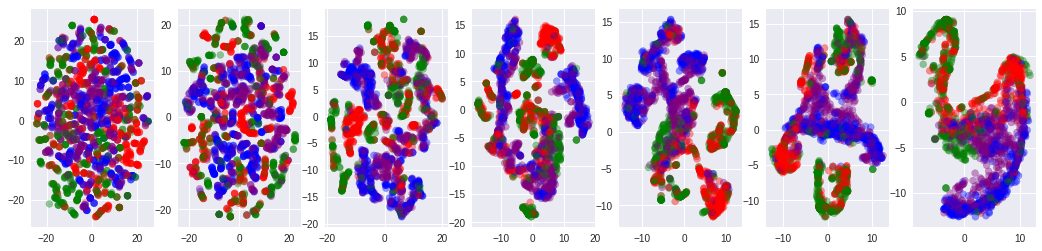

In [8]:
cols=['blue','green','red','purple']
#['clear' 'cloudy' 'haze' 'partly_cloudy']
coltrain=[cols[i] for i in train_labels_cloud[bcc[:trainNum]]]
fig=plt.figure(n_model,figsize=(18,4))
for i in range(n_model):
    a=plt.subplot('1'+str(n_model)+str(i+1))
    a.scatter(tsne[i][:,0],tsne[i][:,1],color=coltrain,alpha=0.4)

Some clustering is evident, but nothing too clean. Let's train a RFC on the balanced data set. The t-sne embedding estimates the similarity of two data point using a Gaussian distribution centered around each point. It then attempts to embed the point in a two dimensional space in a way that preserve the similarity of the higher dimensional data. The perplexity controls the standard deviation used for the initial Gaussian estimate. A low(high) perplexity will try to cluster local(local, but with a larger neighborhood) points together.

In [9]:
from sklearn.model_selection import GridSearchCV as GSCV
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import f1_score

def f1score(clf,x,y):
    return f1_score(y,clf.predict(x),average='weighted')

def RFC_test(features_object_train,features_object_test,trainNum=trainNum,testNum=testNum):
    features_trainwE=features_object_train
    features_testwE=features_object_test
    rfc=RFC()
    rfc=GSCV(RFC(),{'n_estimators':np.arange(1,10,2)*10,'max_features':["auto","sqrt","log2"]})
    print('Training the classifier...')
    rfc.fit(features_trainwE,train_labels_cloud[arraytrain])
    trainscorerfc=rfc.score(features_trainwE,train_labels_cloud[arraytrain])
    testscorerfc=rfc.score(features_testwE,train_labels_cloud[arraytest])
    testlabels=train_labels_cloud[arraytest]
    print('The RFC training score is: ', trainscorerfc)
    print('The RFC test score is:', testscorerfc, ' and the f1 score is ', f1score(rfc,features_testwE,testlabels))
    return rfc

rfc=RFC_test(features_train,features_test)

Training the classifier...
The RFC training score is:  0.9975
The RFC test score is: 0.81  and the f1 score is  0.809043168504


The RFC can almost fit the whole training data set, but there is some overfitting occuring. The features aren't cleanly seperating the cloud labels. This is expected given the t-sne figures.